In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
import time
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
def plot_scores_box_plot(scores, repeats, n_splits):
    plt.figure(figsize=(15, 8))
    plt.boxplot(
        scores.reshape((repeats, n_splits)),
        labels=[str(r) for r in range(1, repeats + 1)],
        showmeans=True,
    )
    plt.ylabel("RMSE", labelpad=20, fontsize=15)
    plt.xlabel("Repeats", labelpad=20, fontsize=15)
    plt.show()

In [3]:
def create_keras_model(
    activation="swish", dropout_rate=0.0, n_units=0, n_layers=0, learning_rate=1e-3
):
    model = tf.keras.Sequential()

    for _ in range(n_layers):
        model.add(tf.keras.layers.Dense(units=n_units, activation=activation))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(1))
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

In [4]:
def get_baseline_model():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Dense(units=32))
    model.add(tf.keras.layers.Dense(units=1))
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(
        optimizer=opt,
        loss="mse",
        metrics=[tf.keras.metrics.RootMeanSquaredError(name="RMSE")],
    )
    return model

In [5]:
def make_repeated_kfold_cross_validation(x, y, params=None):
    if params is not None:
        activation = params["activation"]
        dropout_rate = params["dropout_rate"]
        n_units = params["n_units"]
        n_layers = params["n_layers"]
        learning_rate = params["learning_rate"]

    rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
    scores = []

    start = time.time()
    for train, test in rkf.split(x):
        if params is not None:
            model = create_keras_model(
                activation=activation,
                dropout_rate=dropout_rate,
                n_units=n_units,
                n_layers=n_layers,
                learning_rate=learning_rate,
            )
        else:
            model = get_baseline_model()
        model.fit(
            scaler.fit_transform(x[train]),
            y[train],
            epochs=epochs,
            batch_size=batch_size,
            verbose=0,
        )
        rmse = model.evaluate(scaler.transform(x[test]), y[test], verbose=0)
        scores.append(rmse[1])

    print("RMSE: %.3f (%.3f)" % (np.mean(scores), np.std(scores)))
    end = time.time()
    print("Minutes Elapsed: ", (end - start) / 60)
    return rkf, scores

<h3>Disable Tensorflow Warnings</h3>

In [6]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

## Dataset

The datasets used here were prepared without resampling. The methods used to fill the missings and create new features can be checked in the feature engineering directory in the notebook directory of this project.

In [7]:
df_r3d_and_r7d = pd.read_csv(
    "../../../../data/interim/"
    + "r3d_and_r7d-no-resampling-with-fillna-"
    + "dados-historicos-partner_i-cement-CPIIE40.csv"
)
df_r3d_only = pd.read_csv(
    "../../../../data/interim/"
    + "r3d_only-no-resampling-with-fillna-"
    + "dados-historicos-partner_i-cement-CPIIE40.csv"
)
df_no_r3d_r7d = pd.read_csv(
    "../../../../data/interim/"
    + "no-r3d-r7d-no-resampling-with-fillna-"
    + "dados-historicos-partner_i-cement-CPIIE40.csv"
)

## Feature Selection

### In this notebook we remove variables that could potentially cause data leakage. Thus we are performing testings removing the following variables:

#### IP - Initial setting time
#### FP - Final setting time


#### BL - Blaine specific surface (This is both removed and use)

# Neural Network Feedforward - Multiple layers

<h3>Baseline model</h3>

<h4>Config:</h4>

1. Layers: 1

2. Units: 32

3. Learning rate: 1e-2

In [8]:
seed = 47
scaler = StandardScaler()
repeats = 10
n_splits = 10
epochs = 300
batch_size = 32

# 1. Repeated KFold Cross validation

## 1.1 Dataset: no-r3d-r7d-no-resampling-with-fillna

<h3>Experiment 1</h3>
<h4> Repeated KFold Cross Validation - df_no_r3d_r7d</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

In [9]:
y = df_no_r3d_r7d["R28D"].values
x = df_no_r3d_r7d.drop(["Data/Hora", "R28D", "IP", "FP"], axis=1).values

In [10]:
rkf1, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.129 (0.515)
Minutes Elapsed:  11.764834562937418


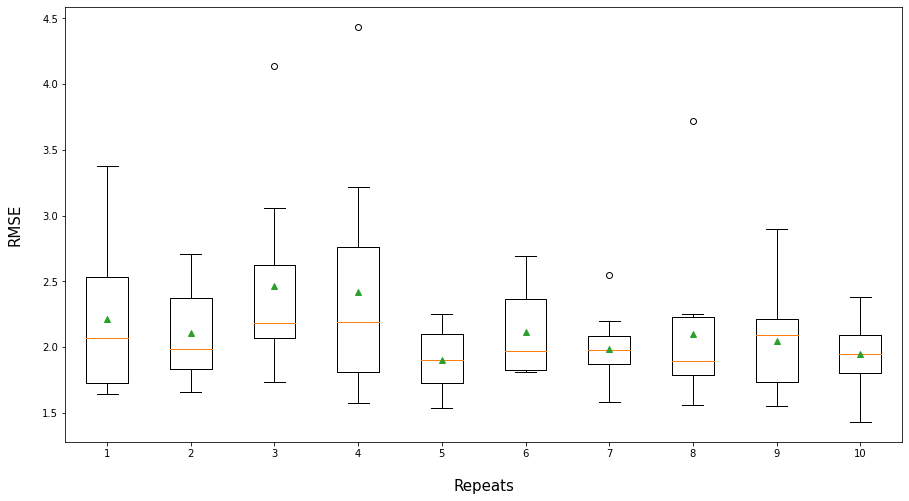

In [11]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 2</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D variables are not considered.

<b>Feature Selection:</b> The BL variable is not used.

In [12]:
y = df_no_r3d_r7d["R28D"].values
x = df_no_r3d_r7d.drop(["Data/Hora", "R28D", "IP", "FP", "BL"], axis=1).values

In [13]:
rkf1_1, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.121 (0.458)
Minutes Elapsed:  11.660392308235169


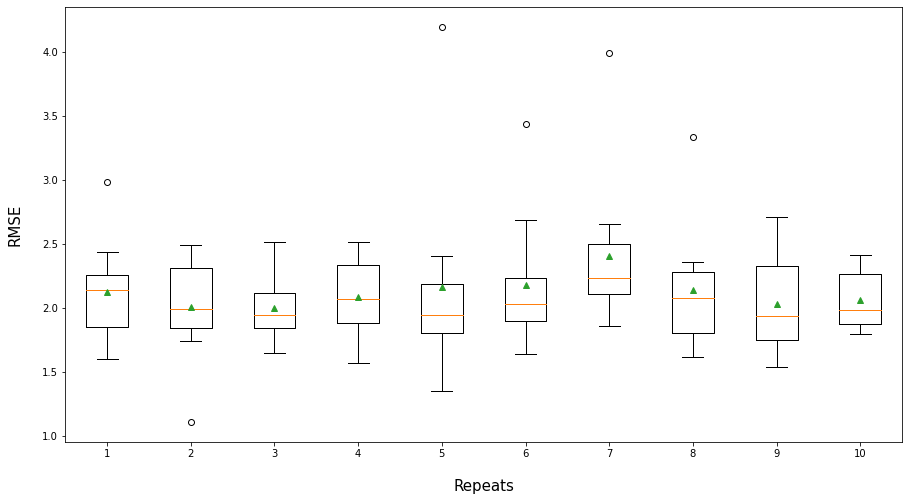

In [14]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 3</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D are not considered

<b>Feature Selection:</b> 

1. The BL variable is not used.
2. High correlated variables are removed

In [15]:
to_drop = [
    "Data/Hora",
    "R28D",
    "IP",
    "FP",
    "BL",
    "CALCITA",
    "DESIDRATAÇÃO",
    "GIPSITA",
    "TIO2",
    "AL2O3",
    "PF",
    "FERRITA",
]
y = df_no_r3d_r7d["R28D"].values
x = df_no_r3d_r7d.drop(to_drop, axis=1).values

In [16]:
rkf1_2, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.022 (0.385)
Minutes Elapsed:  11.646031594276428


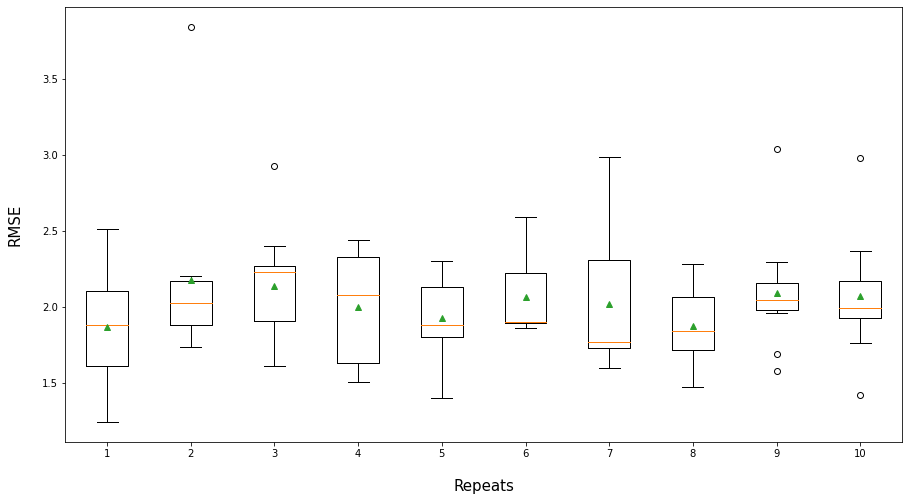

In [17]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

## 1.2 Dataset: r3d_only-no-resampling-with-fillna

<h3>Experiment 4</h3>
<h4> Repeated KFold Cross Validation - df_r3d_only</h4>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

In [18]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D', 'IP', 'FP'], axis=1).values

In [19]:
rkf2, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.088 (0.667)
Minutes Elapsed:  11.820633435249329


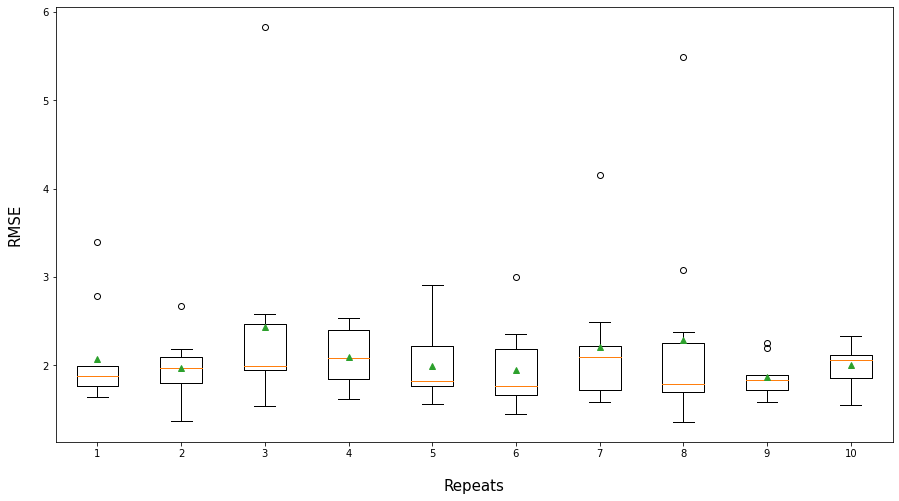

In [20]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 5</h3>
<h4> Repeated KFold Cross Validation - df_r3d_only</h4>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

<b>Feature Selection:</b> The BL variable is not used.

In [21]:
y = df_r3d_only['R28D'].values
x = df_r3d_only.drop(['Data/Hora', 'R28D', 'IP', 'FP', 'BL'], axis=1).values

In [22]:
rkf2_1, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.149 (0.739)
Minutes Elapsed:  11.68449001312256


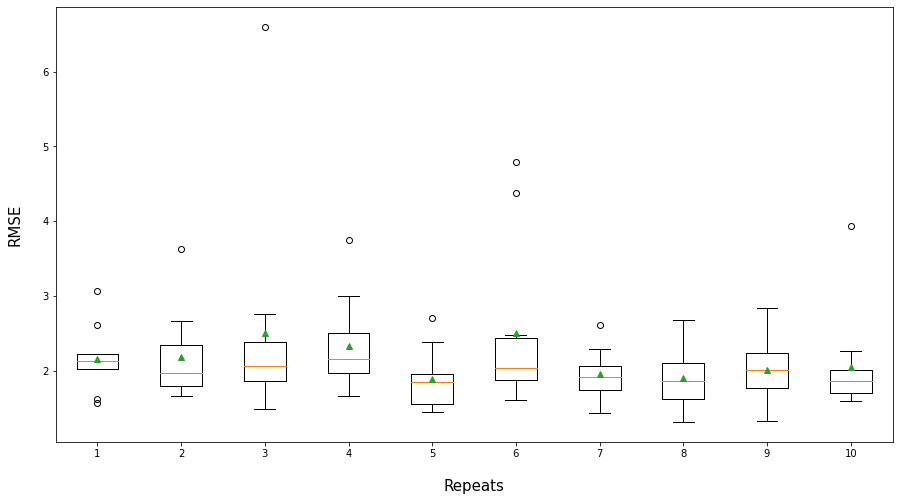

In [23]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 6</h3>
<h4> Repeated KFold Cross Validation - df_r3d_only</h4>

<b>Dataset: df_r3d_only:</b> In this dataset only R3D is considered.

<b>Feature Selection:</b>

1. The BL variable is not used.
2. High correlated variables are removed

In [24]:
to_drop = [
    "Data/Hora",
    "R28D",
    "IP",
    "FP",
    "BL",
    "CALCITA",
    "DESIDRATAÇÃO",
    "GIPSITA",
    "TIO2",
    "AL2O3",
    "PF",
    "FERRITA",
]
y = df_r3d_only["R28D"].values
x = df_r3d_only.drop(to_drop, axis=1).values

In [25]:
rkf2_2, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.093 (0.536)
Minutes Elapsed:  11.718770829836528


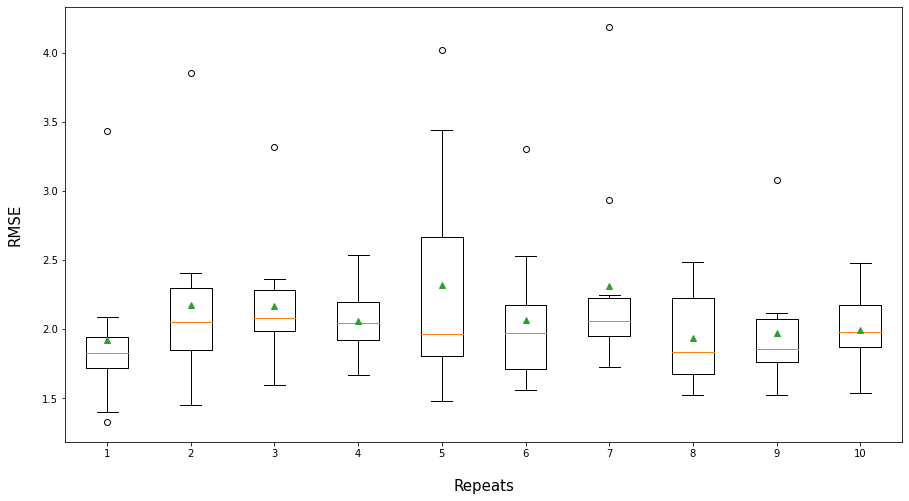

In [26]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

## 1.3 Dataset: r3d_and_r7d-no-resampling-with-fillna

<h3>Experiment 7</h3>
<h4> Repeated KFold Cross Validation - df_r3d_and_r7d</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D are considered.        

In [27]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D', 'IP', 'FP'], axis=1).values

In [28]:
rkf3, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 2.079 (0.906)
Minutes Elapsed:  11.52229147752126


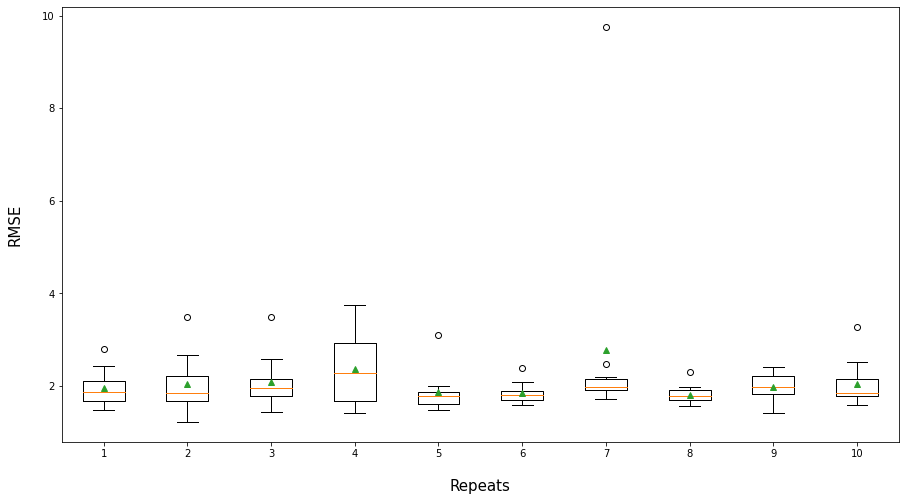

In [29]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 8</h3>
<h4> Repeated KFold Cross Validation - df_r3d-and-rd7</h4>

<b>Dataset: df_r3d_and_r7d:</b> In this dataset both R3D and R7D variables are considered.

<b>Feature Selection:</b> The BL variable is not used.

In [30]:
y = df_r3d_and_r7d['R28D'].values
x = df_r3d_and_r7d.drop(['Data/Hora', 'R28D', 'IP', 'FP', 'BL'], axis=1).values

In [31]:
rkf3_1, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 1.957 (0.652)
Minutes Elapsed:  11.506638399759929


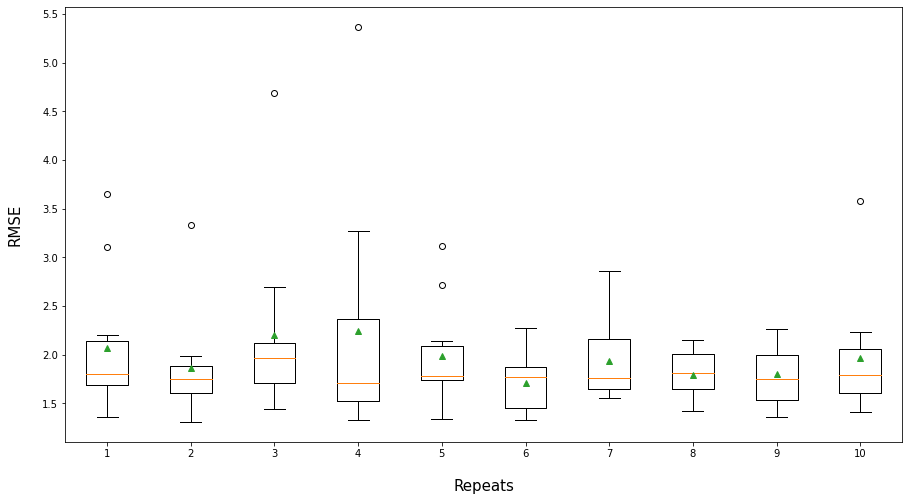

In [32]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)

<h3>Experiment 9</h3>
<h4> Repeated KFold Cross Validation</h4>

<b>Dataset: df_no_r3d_r7d:</b> In this dataset the R3D and R7D are used

<b>Feature Selection:</b> 

1. The BL variable is not used.
2. High correlated variables are removed

In [33]:
to_drop = [
    "Data/Hora",
    "R28D",
    "IP",
    "FP",
    "BL",
    "CALCITA",
    "DESIDRATAÇÃO",
    "GIPSITA",
    "TIO2",
    "AL2O3",
    "PF",
    "FERRITA",
]
y = df_r3d_and_r7d["R28D"].values
x = df_r3d_and_r7d.drop(to_drop, axis=1).values

In [34]:
rkf3_2, scores = make_repeated_kfold_cross_validation(x, y)

RMSE: 1.936 (0.414)
Minutes Elapsed:  11.48365024725596


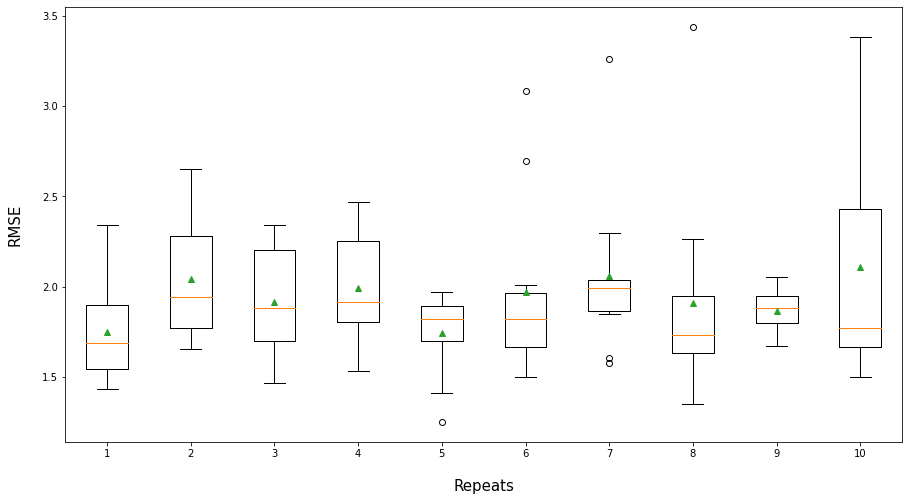

In [35]:
plot_scores_box_plot(np.array(scores), repeats, n_splits)